<a href="https://colab.research.google.com/github/huseyinardaarslan/Text-Classification-Finetuned-DistilBERT/blob/main/Text_Classification_with_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with DistilBERT

In [18]:
# Part 1: Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

Train Dataset Sample:
{'text': "Thorpedo Sinks Phelps' Shot at Spitz Mark (AP) AP - The kid couldn't catch the Thorpedo  #151; and he won't be catching Mark Spitz, either. Michael Phelps' quest for seven gold medals ended after just three events, doomed by another bronze Monday night in the most anticipated race at the Olympic pool  #151; the head-to-head showdown with Australia's Ian Thorpe in the 200-meter freestyle.", 'label': 1}
Test Dataset Sample:
{'text': 'Bombings Hit Kathmandu, as Blockade Starts to Affect Prices The Nepalese capital, Kathmandu, has been hit by bomb blasts on the third day of a blockade called by Maoist rebels. Nepalese business leaders are calling for a cease-fire between the government and the rebels. ', 'label': 0}


<ipython-input-19-45662c6588ca>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette='Set2')


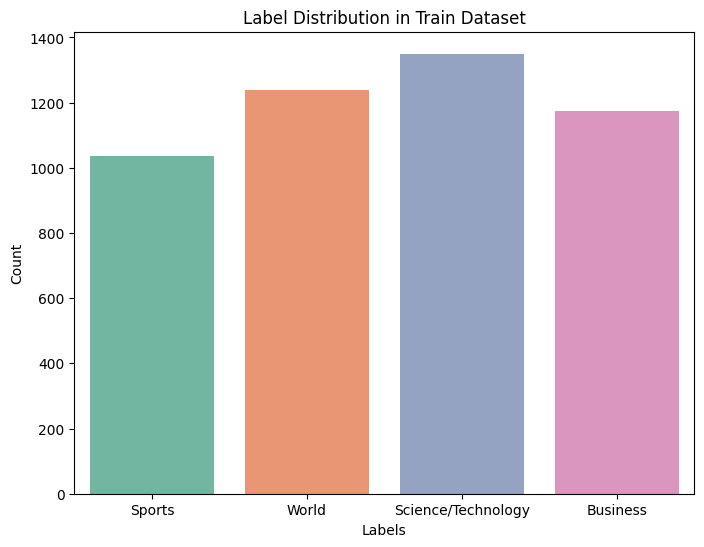

In [19]:
# Part 2: Load and display the dataset (EDA)
dataset = load_dataset("ag_news", split='train[:5%]')
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Displaying some samples of the dataset
print("Train Dataset Sample:")
print(train_dataset[0])

print("Test Dataset Sample:")
print(test_dataset[0])

# Visualize the distribution of labels
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Science/Technology"}
train_labels = [label_map[label] for label in train_dataset['label']]

# Plot label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels, palette='Set2')
plt.title("Label Distribution in Train Dataset")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()


In [20]:
# Part 3: Load distilbert-base-uncased tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)  # Update to 4 labels


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Part 4: Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Tokenize the dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Set to PyTorch format
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [22]:
# Part 5: Prepare for model training and evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
# Part 6: Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.378100,0.269615,0.906667,0.906336,0.906306,0.906667
2,0.169900,0.257127,0.924167,0.924006,0.924467,0.924167


TrainOutput(global_step=600, training_loss=0.3369821734229724, metrics={'train_runtime': 494.4347, 'train_samples_per_second': 19.416, 'train_steps_per_second': 1.214, 'total_flos': 1271732384563200.0, 'train_loss': 0.3369821734229724, 'epoch': 2.0})

In [24]:
# Part 7: Save the fine-tuned model
model.save_pretrained("./finetuned_distilbert")
tokenizer.save_pretrained("./finetuned_distilbert")
print("Fine-tuned model and tokenizer saved.")

Fine-tuned model and tokenizer saved.


In [25]:
# Part 8: Compare Fine-Tuned Model with Pretrained Model
# Load the pretrained model without fine-tuning
pretrained_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# Initialize a new trainer for the pretrained model
pretrained_trainer = Trainer(
    model=pretrained_model,
    args=training_args,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Evaluate the pretrained model on the test dataset
pretrained_eval_result = pretrained_trainer.evaluate()
print("\n--- Pretrained Model Performance ---")
print(f"Test Accuracy: {pretrained_eval_result['eval_accuracy']}")
print(f"Test F1: {pretrained_eval_result['eval_f1']}")
print(f"Test Precision: {pretrained_eval_result['eval_precision']}")
print(f"Test Recall: {pretrained_eval_result['eval_recall']}")

# Evaluate the fine-tuned model again on the test dataset
finetuned_eval_result = trainer.evaluate()
print("\n--- Fine-Tuned Model Performance ---")
print(f"Test Accuracy: {finetuned_eval_result['eval_accuracy']}")
print(f"Test F1: {finetuned_eval_result['eval_f1']}")
print(f"Test Precision: {finetuned_eval_result['eval_precision']}")
print(f"Test Recall: {finetuned_eval_result['eval_recall']}")

# Summary of the comparison
print("\n--- Model Performance Comparison ---")
improvements = {
    'Accuracy Improvement': finetuned_eval_result['eval_accuracy'] - pretrained_eval_result['eval_accuracy'],
    'F1 Score Improvement': finetuned_eval_result['eval_f1'] - pretrained_eval_result['eval_f1'],
    'Precision Improvement': finetuned_eval_result['eval_precision'] - pretrained_eval_result['eval_precision'],
    'Recall Improvement': finetuned_eval_result['eval_recall'] - pretrained_eval_result['eval_recall']
}

for key, value in improvements.items():
    print(f"{key}: {value}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Pretrained Model Performance ---
Test Accuracy: 0.25666666666666665
Test F1: 0.10505426356589148
Test Precision: 0.0660428849902534
Test Recall: 0.25666666666666665



--- Fine-Tuned Model Performance ---
Test Accuracy: 0.9241666666666667
Test F1: 0.9240059821296781
Test Precision: 0.9244666833873086
Test Recall: 0.9241666666666667

--- Model Performance Comparison ---
Accuracy Improvement: 0.6675
F1 Score Improvement: 0.8189517185637867
Precision Improvement: 0.8584237983970553
Recall Improvement: 0.6675


<ipython-input-26-ec6bbc817ada>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette='viridis')


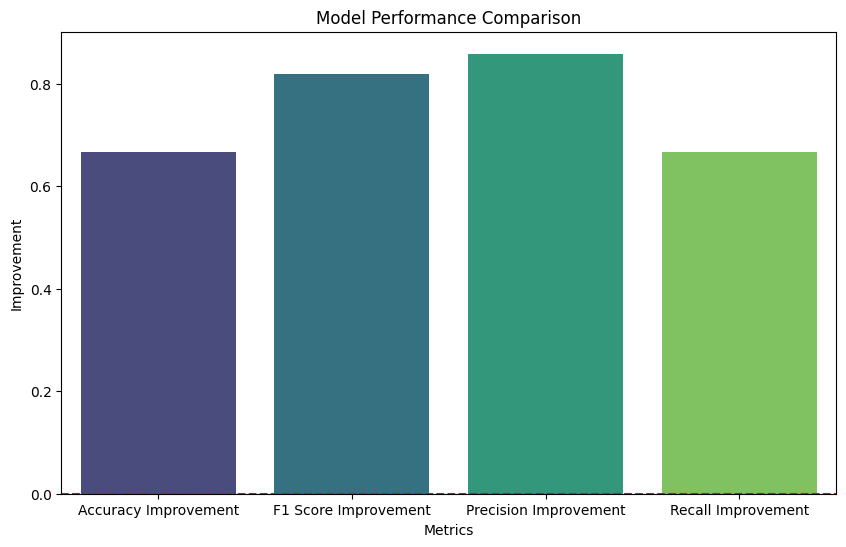

In [26]:
# Part 9: Visualize Model Performance Comparison
labels = list(improvements.keys())
values = list(improvements.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values, palette='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Improvement")
plt.xlabel("Metrics")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [27]:
# Part 10: Model Prediction on Test Data (Fine-tuned and Pretrained Model)
# Select an example from the test dataset
print("--- Test Example and Model Predictions ---")
review_text = test_dataset['text'][2]
true_label = test_dataset['label'][2]
print(f"Review: {review_text}")
print(f"True Label: {true_label} ({label_map[true_label]})")

# Tokenize the review
inputs = tokenizer(review_text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

# Ensure model and inputs are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {key: value.to(device) for key, value in inputs.items()}

# --- Prediction using Pretrained Model ---
print("\n--- Pretrained Model Prediction ---")
pretrained_model.to(device)  # Pretrained model needs to be loaded on the device
outputs_pretrained = pretrained_model(**inputs)
predictions_pretrained = np.argmax(outputs_pretrained.logits.detach().cpu().numpy(), axis=1)
predicted_label_pretrained = predictions_pretrained[0]
predicted_category_pretrained = label_map.get(predicted_label_pretrained, "Unknown")

# Print the pretrained model's prediction
print(f"Pretrained Model Predicted Label: {predicted_label_pretrained}")
print(f"Pretrained Model Predicted Category: {predicted_category_pretrained}")

# --- Prediction using Fine-tuned Model ---
print("\n--- Fine-tuned Model Prediction ---")
model.to(device)  # Fine-tuned model is already loaded
outputs_finetuned = model(**inputs)
predictions_finetuned = np.argmax(outputs_finetuned.logits.detach().cpu().numpy(), axis=1)
predicted_label_finetuned = predictions_finetuned[0]
predicted_category_finetuned = label_map.get(predicted_label_finetuned, "Unknown")

# Print the fine-tuned model's prediction
print(f"Fine-tuned Model Predicted Label: {predicted_label_finetuned}")
print(f"Fine-tuned Model Predicted Category: {predicted_category_finetuned}")

--- Test Example and Model Predictions ---
Review: North Korea  #39;won #39;t pull out of 6-way talks #39; BEIJING - China said yesterday that its close ally North Korea will not be pulling out of six-party talks, despite Pyongyang hinting that Washington #39;s hardline policy made the negotiations unworkable. 
True Label: 0 (World)

--- Pretrained Model Prediction ---
Pretrained Model Predicted Label: 0
Pretrained Model Predicted Category: World

--- Fine-tuned Model Prediction ---
Fine-tuned Model Predicted Label: 0
Fine-tuned Model Predicted Category: World
